In [1]:
!pip install python-dotenv
!pip install langchain
!pip install langgraph

In [2]:
!pip install langchain_openai
!pip install langchain_community langchain_chroma

In [3]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [4]:
from google.colab import userdata
load_dotenv()

# Get the API key from environment variables
openai_api_key = userdata.get("OPENAI_API_KEY")
#openai_api_key = ""

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please set it in your .env file or as a secret.")


In [5]:
!pip install faiss-cpu

In [6]:
from typing import TypedDict, Dict, List

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END


# -------------------------------------------------------------------
# LLM & EMBEDDINGS
# -------------------------------------------------------------------

llm = ChatOpenAI(
    api_key=openai_api_key,
    model="gpt-4o",
    temperature=0
)

embeddings = OpenAIEmbeddings(
    api_key=openai_api_key,
    model="text-embedding-3-large"
)


# -------------------------------------------------------------------
# VECTOR DATABASE (FRAUD / AML KNOWLEDGE)
# -------------------------------------------------------------------

documents = [
    Document(page_content="Rapid high-value transactions may indicate account takeover."),
    Document(page_content="Transactions inconsistent with historical behavior are strong fraud indicators."),
    Document(page_content="Cross-border transfers above thresholds require enhanced AML checks."),
    Document(page_content="Multiple failed logins followed by a large transfer indicate fraud."),
    Document(page_content="Dormant accounts suddenly becoming active is a known laundering pattern.")
]

vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

In [15]:
# -------------------------------------------------------------------
# UPDATED SHARED STATE
# -------------------------------------------------------------------

class FraudState(TypedDict):
    transaction: Dict[str, float]
    user_profile: Dict[str, float]
    remaining_agents: List[str]

    behavior_assessment: str
    pattern_assessment: str
    compliance_assessment: str

    final_risk: str
    action: str


# -------------------------------------------------------------------
# ORCHESTRATOR (SEQUENTIAL PLANNER)
# -------------------------------------------------------------------

import json

def orchestrator_agent(state: FraudState):

    prompt = f"""
    You are a fraud investigation planner.

    Transaction:
    {state["transaction"]}

    User profile:
    {state["user_profile"]}

    Decide execution order using:
    - behavior
    - pattern
    - compliance

    Respond ONLY in JSON:

    {{
        "execution_order": ["behavior", "pattern", "compliance"]
    }}
    """

    response = llm.invoke(prompt).content.strip()

    try:
        parsed = json.loads(response)
        state["remaining_agents"] = parsed["execution_order"]
    except:
        state["remaining_agents"] = ["behavior", "pattern", "compliance"]

    return state




def first_router(state: FraudState):
    return state["remaining_agents"][0]



In [16]:
def behavior_agent(state: FraudState):
    state["behavior_assessment"] = llm.invoke(
        f"Assess behavior risk: {state['user_profile']}"
    ).content

    state["remaining_agents"].pop(0)
    return state


def pattern_agent(state: FraudState):
    retrieved = retriever.invoke("transaction anomaly")
    context = "\n".join(d.page_content for d in retrieved)

    state["pattern_assessment"] = llm.invoke(
        f"Assess pattern risk using context:\n{context}"
    ).content

    state["remaining_agents"].pop(0)
    return state


def compliance_agent(state: FraudState):
    state["compliance_assessment"] = llm.invoke(
        f"Assess AML risk: {state['transaction']}"
    ).content

    state["remaining_agents"].pop(0)
    return state


In [17]:
def judge_agent(state: FraudState):
    prompt = f"""
    You are a senior fraud risk judge.

    Behavior assessment:
    {state.get("behavior_assessment", "")}

    Pattern assessment:
    {state.get("pattern_assessment", "")}

    Compliance assessment:
    {state.get("compliance_assessment", "")}

    Decide overall fraud risk.

    Respond with exactly one word:
    LOW, MEDIUM, or HIGH
    """

    state["final_risk"] = llm.invoke(prompt).content.strip()
    return state


In [18]:
def action_agent(state: FraudState):

    risk = state.get("final_risk", "LOW")

    if "HIGH" in risk:
        state["action"] = "BLOCK_TRANSACTION"
    elif "MEDIUM" in risk:
        state["action"] = "ESCALATE_TO_HUMAN"
    else:
        state["action"] = "ALLOW_TRANSACTION"

    return state


In [19]:
def report_node(state: FraudState):

    print("\n========== FRAUD INVESTIGATION REPORT ==========")
    print("Transaction:", state["transaction"])
    print("User Profile:", state["user_profile"])
    print("\nBehavior Assessment:\n", state.get("behavior_assessment", "N/A"))
    print("\nPattern Assessment:\n", state.get("pattern_assessment", "N/A"))
    print("\nCompliance Assessment:\n", state.get("compliance_assessment", "N/A"))
    print("\nFINAL RISK:", state.get("final_risk", "UNKNOWN"))
    print("ACTION:", state.get("action", "NONE"))
    print("===============================================\n")

    return state


In [20]:
graph = StateGraph(FraudState)

graph.add_node("orchestrator", orchestrator_agent)
graph.add_node("behavior", behavior_agent)
graph.add_node("pattern", pattern_agent)
graph.add_node("compliance", compliance_agent)
graph.add_node("judge", judge_agent)
graph.add_node("action", action_agent)
graph.add_node("report", report_node)

graph.set_entry_point("orchestrator")

graph.add_conditional_edges(
    "orchestrator",
    first_router,
    {
        "behavior": "behavior",
        "pattern": "pattern",
        "compliance": "compliance"
    }
)

# Fixed sequential flow
graph.add_edge("behavior", "pattern")
graph.add_edge("pattern", "compliance")
graph.add_edge("compliance", "judge")
graph.add_edge("judge", "action")
graph.add_edge("action", "report")
graph.add_edge("report", END)

app = graph.compile()


In [21]:
app.invoke({
    "transaction": {
        "amount": 15000,
        "country_risk_score": 0.9,
        "hour": 2
    },
    "user_profile": {
        "account_age_years": 0.4,
        "avg_transaction": 300,
        "login_failures": 5
    },
    "remaining_agents": [],
    "behavior_assessment": "",
    "pattern_assessment": "",
    "compliance_assessment": "",
    "final_risk": "",
    "action": ""
})



========== FRAUD INVESTIGATION REPORT ==========
Transaction: {'amount': 15000, 'country_risk_score': 0.9, 'hour': 2}
User Profile: {'account_age_years': 0.4, 'avg_transaction': 300, 'login_failures': 5}

Behavior Assessment:
 To assess the behavior risk of this account, we need to consider the provided factors: account age, average transaction amount, and login failures. Here's a breakdown of each factor:

1. **Account Age (0.4 years):**
   - An account age of 0.4 years (approximately 5 months) is relatively new. Newer accounts can sometimes be riskier because they haven't established a long history of behavior. Fraudulent accounts are often created and used quickly before being detected.

2. **Average Transaction Amount ($300):**
   - An average transaction amount of $300 is moderate. The risk associated with this depends on the typical transaction amounts for similar accounts. If this is significantly higher than average for new accounts, it could be a red flag.

3. **Login Failure

{'transaction': {'amount': 15000, 'country_risk_score': 0.9, 'hour': 2},
 'user_profile': {'account_age_years': 0.4,
  'avg_transaction': 300,
  'login_failures': 5},
 'remaining_agents': [],
 'behavior_assessment': "To assess the behavior risk of this account, we need to consider the provided factors: account age, average transaction amount, and login failures. Here's a breakdown of each factor:\n\n1. **Account Age (0.4 years):**\n   - An account age of 0.4 years (approximately 5 months) is relatively new. Newer accounts can sometimes be riskier because they haven't established a long history of behavior. Fraudulent accounts are often created and used quickly before being detected.\n\n2. **Average Transaction Amount ($300):**\n   - An average transaction amount of $300 is moderate. The risk associated with this depends on the typical transaction amounts for similar accounts. If this is significantly higher than average for new accounts, it could be a red flag.\n\n3. **Login Failures (

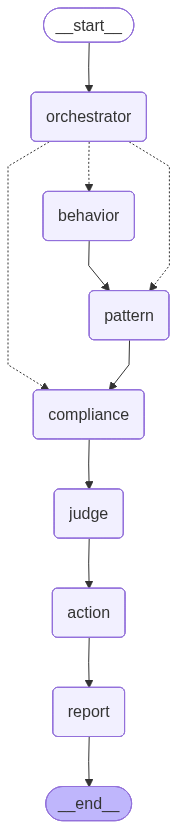

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))